### Import Libraries

In [10]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print('tensorflow version',tf.__version__)

tensorflow version 2.15.0


### Exploring Dataset

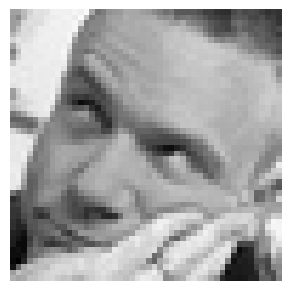

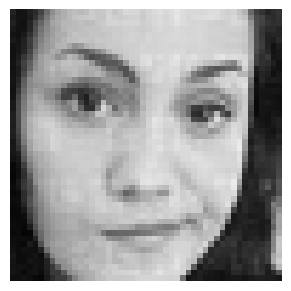

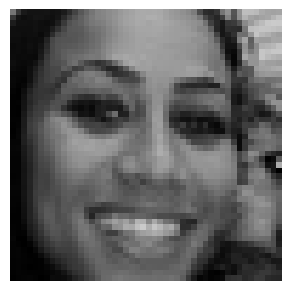

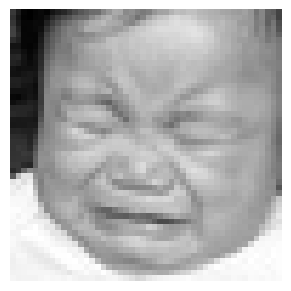

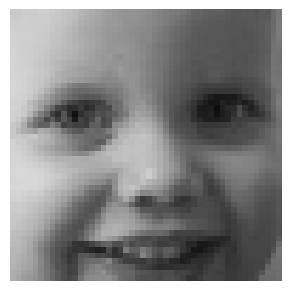

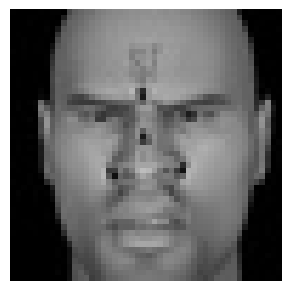

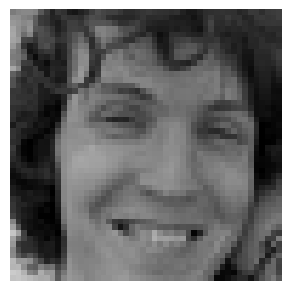

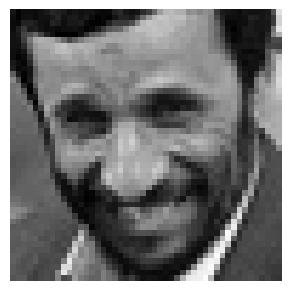

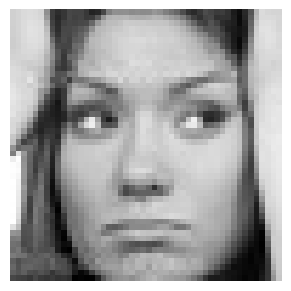

In [2]:
images = glob("train/**/**")

for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image)),plt.axis('off')

### Data Preparation

In [3]:
img_size = 48
batch_size = 64
datagen_train  = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory('train/',target_size=(img_size,img_size),
                                                    color_mode='grayscale',batch_size=batch_size,class_mode='categorical',
                                                   shuffle=True)



datagen_validation  = ImageDataGenerator()
validation_generator = datagen_validation.flow_from_directory('test/',target_size=(img_size,img_size),
                                                    color_mode='grayscale',batch_size=batch_size,class_mode='categorical',
                                                   shuffle=True)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Defining the Model

In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

    

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x
    

In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(7, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model




In [11]:
model = model_fer((48,48,1))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0   

### Initializing the model

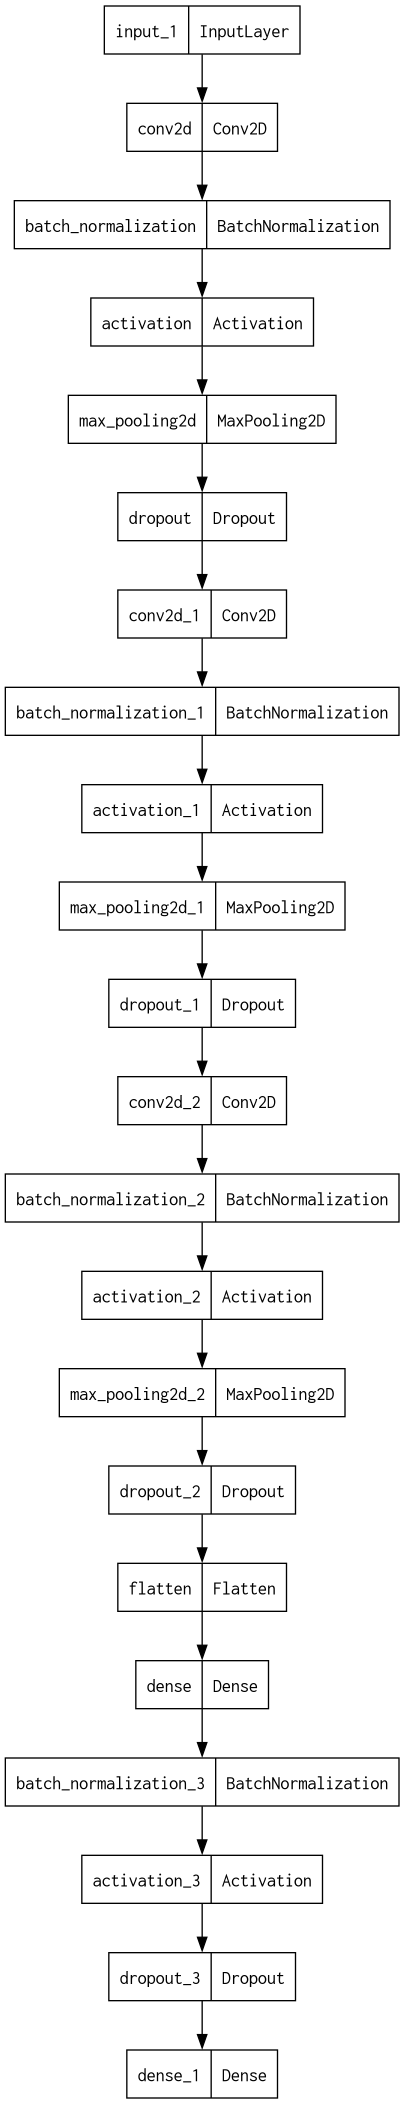

In [9]:
from keras.utils import plot_model
plot_model(model)

In [8]:
epochs = 25
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

callbacks  = [checkpoint]


### Training the model

In [16]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/25
448/448 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.7284
Epoch 1: saving model to model_weights.weights.h5
448/448 [==============================] - 113s 251ms/step - loss: 0.7305 - accuracy: 0.7284 - val_loss: 1.0633 - val_accuracy: 0.6226
Epoch 2/25
448/448 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.7446
Epoch 2: saving model to model_weights.weights.h5
448/448 [==============================] - 605s 1s/step - loss: 0.6898 - accuracy: 0.7446 - val_loss: 1.1995 - val_accuracy: 0.5773
Epoch 3/25
448/448 [==============================] - ETA: 0s - loss: 0.6676 - accuracy: 0.7535
Epoch 3: saving model to model_weights.weights.h5
448/448 [==============================] - 125s 279ms/step - loss: 0.6676 - accuracy: 0.7535 - val_loss: 1.1400 - val_accuracy: 0.5991
Epoch 4/25
448/448 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.7653
Epoch 4: saving model to model_weights.weights.h5
448/448 [=====

### Model evaluation

In [17]:
model.evaluate(validation_generator)

113/113 [==============================] - 15s 133ms/step - loss: 1.3441 - accuracy: 0.6147


[1.3440515995025635, 0.6146559119224548]

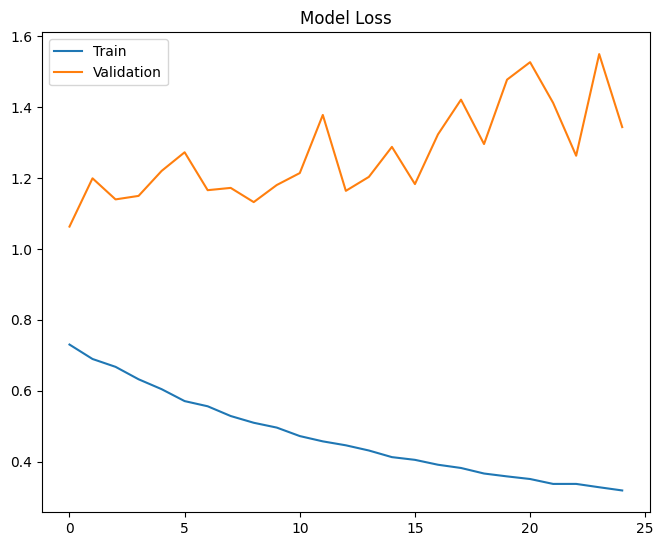

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

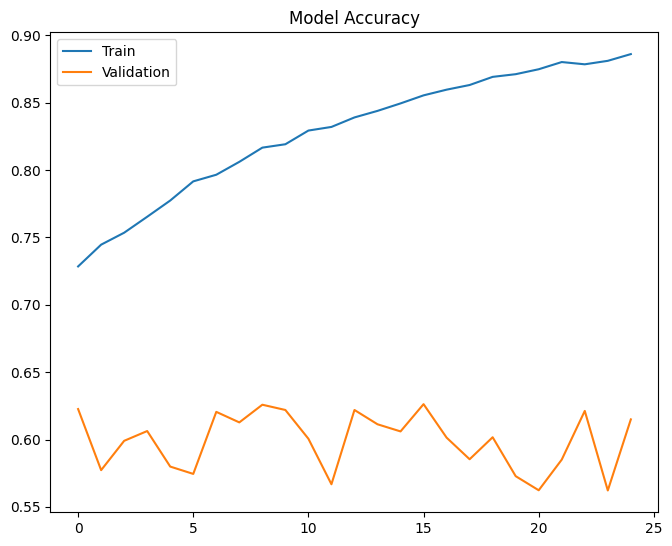

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [20]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)